# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_44', 'ORACLE.run2_26', 'ORACLE.run2_38', 'ORACLE.run2_50', 'ORACLE.run2_14', 'ORACLE.run2_32'}


{'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_14', 'ORACLE.run1_26', 'ORACLE.run1_44', 'ORACLE.run1_32', 'ORACLE.run1_20', 'ORACLE.run1_8'}


tensor([[[ 0.9296,  0.0939, -1.0517,  ...,  0.2911,  1.4179,  0.1502],
         [ 0.3944,  1.1831, -0.4789,  ..., -0.9578, -0.0751, -1.0610]],

        [[ 0.9965,  0.3760, -1.1469,  ..., -0.2538,  1.2410, -0.3666],
         [ 0.0564,  1.0153, -0.1034,  ..., -1.2316, -0.6769, -1.0247]],

        [[ 0.2116,  1.1347, -0.5866,  ..., -1.2694,  0.7597,  0.2308],
         [-0.5770,  0.4135,  0.7309,  ..., -0.5385, -1.1155, -0.9328]],

        ...,

        [[ 0.0523, -1.2806,  0.2417,  ...,  1.2283, -0.3332,  0.0849],
         [ 0.6729, -0.0719, -0.8167,  ...,  0.0000,  1.3132,  1.0258]],

        [[ 0.7392, -0.5706, -0.9337,  ...,  1.1152,  0.9207, -0.3825],
         [ 0.9596,  0.4409, -1.0115,  ..., -0.5511, -0.3890, -1.2903]],

        [[ 0.3781, -0.7040, -0.4367,  ...,  1.1081,  1.1473,  0.7301],
         [ 1.0821,  0.5150, -1.2907,  ..., -0.3259,  0.7040, -1.0821]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 48.3571, train_label_loss: 2.8420, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3139.7144, train_label_loss: 0.9604, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3142.8025, train_label_loss: 0.5612, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3136.1998, train_label_loss: 0.4998, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3131.3770, train_label_loss: 1.3082, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3140.8827, train_label_loss: 0.9434, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3146.3184, train_label_loss: 0.8388, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3138.7269, train_label_loss: 0.5061, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3142.4283, train_label_loss: 0.4304, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3137.6662, train_label_loss: 0.8912, 


epoch: 1, source_val_acc_label: 0.5473, target_val_acc_label: 0.5499, source_val_label_loss: 137.5783, target_val_label_loss: 164.0718, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.7055, train_label_loss: 428.2420, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3149.1822, train_label_loss: 0.6962, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3166.4174, train_label_loss: 0.6175, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3156.4931, train_label_loss: 0.5347, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3160.9398, train_label_loss: 0.6338, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3150.1745, train_label_loss: 1.0482, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3156.4984, train_label_loss: 1.2862, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3159.0381, train_label_loss: 0.9291, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3158.9755, train_label_loss: 1.2129, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3174.0275, train_label_loss: 0.5638, 


epoch: 2, source_val_acc_label: 0.7621, target_val_acc_label: 0.7654, source_val_label_loss: 0.7219, target_val_label_loss: 0.6779, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.7172, train_label_loss: 0.7306, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3149.9647, train_label_loss: 0.3306, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3152.8296, train_label_loss: 0.4854, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3145.0985, train_label_loss: 0.6279, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3143.6016, train_label_loss: 0.4732, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3165.7356, train_label_loss: 0.7893, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3169.0612, train_label_loss: 0.9291, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3152.9653, train_label_loss: 0.2718, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3154.7173, train_label_loss: 0.4958, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3157.4870, train_label_loss: 0.2727, 


epoch: 3, source_val_acc_label: 0.8009, target_val_acc_label: 0.8062, source_val_label_loss: 0.5975, target_val_label_loss: 0.5653, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.7225, train_label_loss: 0.4440, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3150.0532, train_label_loss: 0.2067, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3159.3740, train_label_loss: 0.8914, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3161.8097, train_label_loss: 0.7145, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3150.6556, train_label_loss: 0.3488, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3168.9423, train_label_loss: 0.1352, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3161.0725, train_label_loss: 0.7070, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3156.8317, train_label_loss: 0.6416, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3068.6967, train_label_loss: 0.4937, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3043.8717, train_label_loss: 0.5525, 


epoch: 4, source_val_acc_label: 0.8242, target_val_acc_label: 0.8229, source_val_label_loss: 0.5115, target_val_label_loss: 0.5028, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 4.4522, train_label_loss: 0.2583, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2998.7886, train_label_loss: 0.1833, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2987.6364, train_label_loss: 0.3577, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2958.1332, train_label_loss: 0.6208, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2976.8081, train_label_loss: 0.3209, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2996.9062, train_label_loss: 0.7665, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3007.5900, train_label_loss: 0.6859, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3074.3568, train_label_loss: 0.3660, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3019.2054, train_label_loss: 0.8233, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3058.2839, train_label_loss: 0.3520, 


epoch: 5, source_val_acc_label: 0.8478, target_val_acc_label: 0.8463, source_val_label_loss: 0.4399, target_val_label_loss: 0.4370, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 4.5169, train_label_loss: 0.3845, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3099.3822, train_label_loss: 0.5933, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3051.0427, train_label_loss: 0.4222, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3124.2273, train_label_loss: 0.2234, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3115.4576, train_label_loss: 0.7951, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3132.0071, train_label_loss: 0.3481, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3130.2174, train_label_loss: 0.5342, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3122.7770, train_label_loss: 0.2637, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3130.6380, train_label_loss: 0.1426, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3125.4650, train_label_loss: 0.1164, 


epoch: 6, source_val_acc_label: 0.8545, target_val_acc_label: 0.8539, source_val_label_loss: 0.4194, target_val_label_loss: 0.4201, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.6301, train_label_loss: 0.2349, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3113.0827, train_label_loss: 0.7984, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3116.8836, train_label_loss: 0.3006, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3112.1908, train_label_loss: 0.2755, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3113.9769, train_label_loss: 0.2801, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3118.4150, train_label_loss: 0.4424, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3126.9798, train_label_loss: 0.3777, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3117.2735, train_label_loss: 0.2946, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3098.1453, train_label_loss: 0.0460, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3098.0194, train_label_loss: 0.2294, 


epoch: 7, source_val_acc_label: 0.8506, target_val_acc_label: 0.8488, source_val_label_loss: 0.4147, target_val_label_loss: 0.4272, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.7261, train_label_loss: 0.6147, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3146.6942, train_label_loss: 0.8247, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3147.8701, train_label_loss: 0.5939, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3165.6167, train_label_loss: 0.5453, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3159.4714, train_label_loss: 0.2599, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3165.2081, train_label_loss: 0.4211, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3157.8833, train_label_loss: 0.7026, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3154.6064, train_label_loss: 0.3958, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3150.2271, train_label_loss: 0.0572, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3153.5707, train_label_loss: 0.2012, 


epoch: 8, source_val_acc_label: 0.8608, target_val_acc_label: 0.8549, source_val_label_loss: 0.3900, target_val_label_loss: 0.4016, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.6856, train_label_loss: 0.2385, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3152.3275, train_label_loss: 0.1566, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3159.6438, train_label_loss: 0.1874, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3139.7142, train_label_loss: 0.1046, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3139.4429, train_label_loss: 0.0786, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3160.6236, train_label_loss: 0.5324, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3154.6318, train_label_loss: 0.5999, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3163.2100, train_label_loss: 0.0467, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3167.3805, train_label_loss: 0.0529, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3162.1383, train_label_loss: 0.1926, 


epoch: 9, source_val_acc_label: 0.8707, target_val_acc_label: 0.8623, source_val_label_loss: 0.3671, target_val_label_loss: 0.3964, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 4.6864, train_label_loss: 0.6786, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3144.9369, train_label_loss: 0.1802, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3166.7942, train_label_loss: 0.2445, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3170.4178, train_label_loss: 0.3920, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3152.8340, train_label_loss: 0.2951, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3165.0422, train_label_loss: 0.2994, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3167.5237, train_label_loss: 0.4201, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3152.5927, train_label_loss: 0.2997, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3164.4151, train_label_loss: 0.3475, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3171.1819, train_label_loss: 0.0905, 


epoch: 10, source_val_acc_label: 0.8763, target_val_acc_label: 0.8651, source_val_label_loss: 0.3451, target_val_label_loss: 0.3810, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 4.7028, train_label_loss: 0.1776, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3132.6192, train_label_loss: 0.2845, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3154.5477, train_label_loss: 0.2595, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3157.6420, train_label_loss: 0.1694, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3151.8005, train_label_loss: 0.3417, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3163.9429, train_label_loss: 0.2390, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3161.1912, train_label_loss: 0.1795, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3151.0215, train_label_loss: 0.0536, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3159.1157, train_label_loss: 0.0326, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3159.3111, train_label_loss: 0.1373, 


epoch: 11, source_val_acc_label: 0.8870, target_val_acc_label: 0.8756, source_val_label_loss: 0.3166, target_val_label_loss: 0.3604, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 4.6933, train_label_loss: 0.4688, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3149.3433, train_label_loss: 0.2503, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3149.1265, train_label_loss: 0.2654, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3157.3086, train_label_loss: 0.4137, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3148.3556, train_label_loss: 0.2311, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3162.4860, train_label_loss: 0.1264, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3154.4869, train_label_loss: 0.0577, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3154.5260, train_label_loss: 0.1471, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3156.2357, train_label_loss: 0.1395, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3153.5919, train_label_loss: 0.1103, 


epoch: 12, source_val_acc_label: 0.8776, target_val_acc_label: 0.8654, source_val_label_loss: 0.3409, target_val_label_loss: 0.3903, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.7016, train_label_loss: 0.2586, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3122.8792, train_label_loss: 0.2893, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3131.4201, train_label_loss: 0.3051, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3158.3303, train_label_loss: 0.0798, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3149.3964, train_label_loss: 0.1654, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3171.6538, train_label_loss: 0.0643, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3164.1900, train_label_loss: 0.2831, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3158.6566, train_label_loss: 0.0568, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3171.3627, train_label_loss: 0.0772, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3153.0666, train_label_loss: 0.3572, 


epoch: 13, source_val_acc_label: 0.8890, target_val_acc_label: 0.8755, source_val_label_loss: 0.3188, target_val_label_loss: 0.3505, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.6924, train_label_loss: 0.1867, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3155.3170, train_label_loss: 0.2976, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3164.2495, train_label_loss: 0.2224, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3156.1066, train_label_loss: 0.0779, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3153.8839, train_label_loss: 0.3318, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3159.9839, train_label_loss: 0.1952, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3168.1364, train_label_loss: 0.3320, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3156.8823, train_label_loss: 0.1217, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3154.5557, train_label_loss: 0.0190, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3159.9737, train_label_loss: 0.1299, 


epoch: 14, source_val_acc_label: 0.8980, target_val_acc_label: 0.8825, source_val_label_loss: 0.2907, target_val_label_loss: 0.3373, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 4.6764, train_label_loss: 0.2710, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3161.3330, train_label_loss: 0.1548, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3150.9897, train_label_loss: 0.3966, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3148.7316, train_label_loss: 0.1416, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3149.2559, train_label_loss: 0.2811, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3159.4399, train_label_loss: 0.1590, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3158.9574, train_label_loss: 0.5286, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 3150.9717, train_label_loss: 0.4323, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3156.9124, train_label_loss: 0.1012, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3159.5808, train_label_loss: 0.1226, 


epoch: 15, source_val_acc_label: 0.8901, target_val_acc_label: 0.8764, source_val_label_loss: 0.3190, target_val_label_loss: 0.3626, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 4.7082, train_label_loss: 0.1456, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3131.4942, train_label_loss: 0.0505, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3154.2076, train_label_loss: 0.0805, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3159.0550, train_label_loss: 0.3317, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3154.7359, train_label_loss: 0.2698, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3164.4152, train_label_loss: 0.1802, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3157.4898, train_label_loss: 0.4248, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3153.2766, train_label_loss: 0.1742, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3165.3200, train_label_loss: 0.3976, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3166.3174, train_label_loss: 0.0742, 


epoch: 16, source_val_acc_label: 0.8786, target_val_acc_label: 0.8655, source_val_label_loss: 0.3452, target_val_label_loss: 0.3922, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.7038, train_label_loss: 0.2348, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3122.3703, train_label_loss: 0.0700, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3147.0292, train_label_loss: 0.0827, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3161.0325, train_label_loss: 0.5099, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3150.9272, train_label_loss: 0.0593, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3171.3791, train_label_loss: 0.3888, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3158.2677, train_label_loss: 0.1475, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3153.7838, train_label_loss: 0.0659, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3158.6654, train_label_loss: 0.1578, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3163.1152, train_label_loss: 0.5509, 


epoch: 17, source_val_acc_label: 0.8973, target_val_acc_label: 0.8841, source_val_label_loss: 0.2975, target_val_label_loss: 0.3421, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 4.6892, train_label_loss: 0.2533, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 3154.4159, train_label_loss: 0.0380, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3142.3436, train_label_loss: 0.1917, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 3159.2343, train_label_loss: 0.4408, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 3147.2935, train_label_loss: 0.2459, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3170.7009, train_label_loss: 0.1727, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3158.0268, train_label_loss: 0.2508, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 3153.8294, train_label_loss: 0.1046, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3165.7990, train_label_loss: 0.1145, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3166.4235, train_label_loss: 0.3241, 


epoch: 18, source_val_acc_label: 0.8916, target_val_acc_label: 0.8765, source_val_label_loss: 0.3121, target_val_label_loss: 0.3601, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

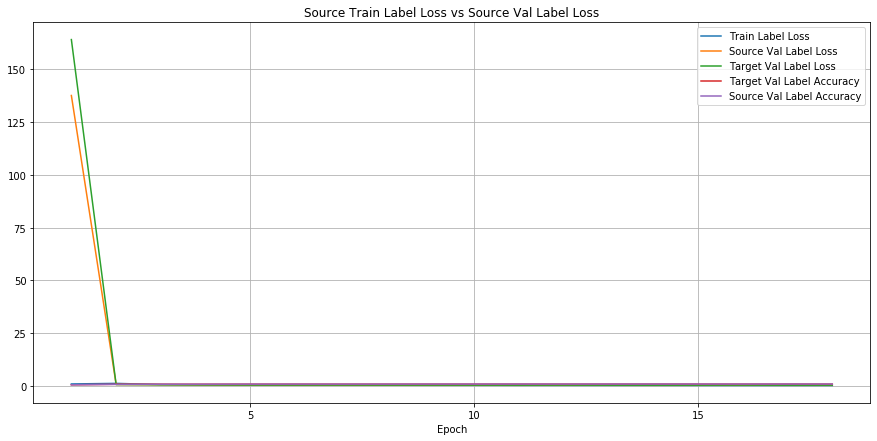

In [25]:
ax = get_loss_curve(experiment)
plt.show()

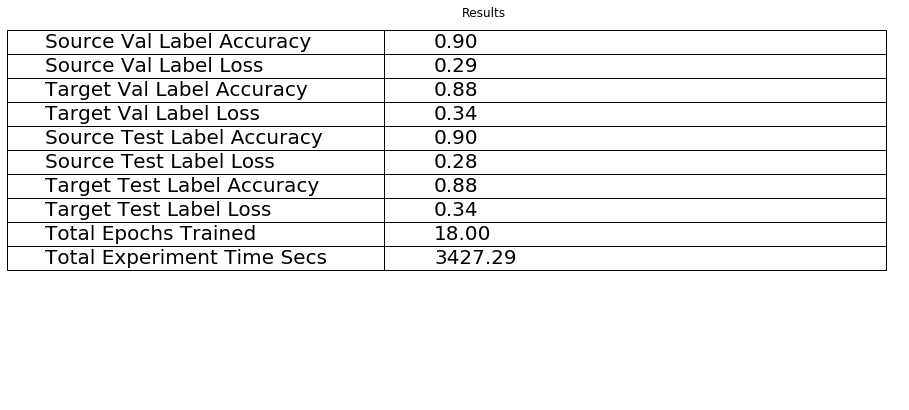

In [26]:
get_results_table(experiment)

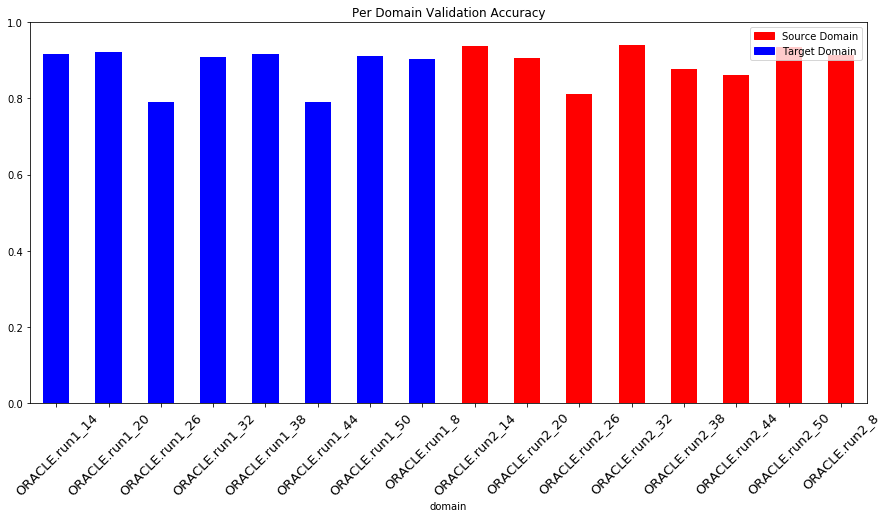

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9 Target Test Label Accuracy: 0.88408203125
Source Val Label Accuracy: 0.8979817708333333 Target Val Label Accuracy: 0.88251953125


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1_oracle.run1-oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480